# Hierarchical clustering with autoencoders

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
from sklearn.datasets import load_iris, load_digits
from sklearn.preprocessing import OneHotEncoder
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.manifold import TSNE

Let's import a toy data set just to provide a proof of concept:

X shape: (1797, 64)
Classes: [0 1 2 3 4 5 6 7 8 9]


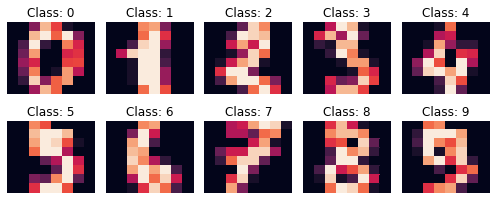

0.0

In [2]:
X, y = load_digits(return_X_y=True)
scaler = MinMaxScaler((0, 1))
X = scaler.fit_transform(X)


print(f'X shape: {X.shape}\nClasses: {np.unique(y)}')

# show the first ten images
figs = X[:10].reshape((10, 8, 8))
plt.figure(figsize=[7, 7])
for i, fig in enumerate(figs):
    plt.subplot(5, 5, i+1)
    plt.title(f'Class: {y[i]}')
    sns.heatmap(fig, cbar=False)
    plt.axis('off')
plt.tight_layout()
plt.show()

X.min()

In [3]:
X_train_np, X_test_np, y_train_np, y_test_np = train_test_split(X, y, test_size=0.33, random_state=42)
x_train = torch.FloatTensor(X_train_np)
y_train = torch.FloatTensor(y_train_np)
x_test = torch.FloatTensor(X_test_np)
y_test = torch.FloatTensor(y_test_np)

x_train.shape

torch.Size([1203, 64])

Let's define a very naive autoencoder. We'll use it to reduce the dimensionality of the input data:

In [12]:
class AutoencoderStandard(nn.Module):
    def __init__(self, input_size):
        super(AutoencoderStandard, self).__init__()
        
        self.input_size = input_size
        
        self.relu = nn.Tanh()
        self.enc1 = nn.Linear(in_features=input_size, out_features=input_size//5)
        self.enc2 = nn.Linear(in_features=input_size//5, out_features=2)
 
        # decoder 
        self.dec1 = nn.Linear(in_features=2, out_features=input_size//5)
        self.dec2 = nn.Linear(in_features=input_size//5, out_features=input_size)
 
    def forward(self, x):
        p1 = self.enc1(x)
        p1 = self.relu(p1)
        p2 = self.enc2(p1)
        
        p3 = self.dec1(p2)
        p3 = self.relu(p3)
        p4 = self.dec2(p3)
        return p4, p2

Train autoencoder:

In [5]:
input_size = x_train.shape[1]
model = AutoencoderStandard(input_size)
print(model)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
model.train()
epoch = 2000
for epoch in range(epoch):
    optimizer.zero_grad()
    
    # Forward pass
    x_reconstruction, p2 = model(x_train)

    # Compute Loss
    #loss_q = quantization(p2.T, x_train.T) / len(x_train)
    loss = torch.nn.functional.mse_loss(x_reconstruction, x_train)
    
    if epoch % 100 == 0:
        print(f'Epoch {epoch + 1}: '
              f'loss: {loss.item():.4f} ')

    # Backward pass
    loss.backward()
    optimizer.step()

AutoencoderStandard(
  (relu): Tanh()
  (enc1): Linear(in_features=64, out_features=12, bias=True)
  (enc2): Linear(in_features=12, out_features=2, bias=True)
  (dec1): Linear(in_features=2, out_features=12, bias=True)
  (dec2): Linear(in_features=12, out_features=64, bias=True)
)
Epoch 1: loss: 0.3312 
Epoch 101: loss: 0.0886 
Epoch 201: loss: 0.0686 
Epoch 301: loss: 0.0646 
Epoch 401: loss: 0.0616 
Epoch 501: loss: 0.0589 
Epoch 601: loss: 0.0568 
Epoch 701: loss: 0.0553 
Epoch 801: loss: 0.0544 
Epoch 901: loss: 0.0538 
Epoch 1001: loss: 0.0533 
Epoch 1101: loss: 0.0527 
Epoch 1201: loss: 0.0521 
Epoch 1301: loss: 0.0515 
Epoch 1401: loss: 0.0508 
Epoch 1501: loss: 0.0500 
Epoch 1601: loss: 0.0492 
Epoch 1701: loss: 0.0483 
Epoch 1801: loss: 0.0475 
Epoch 1901: loss: 0.0468 


Now we have our data projected in a lower dimensional space:

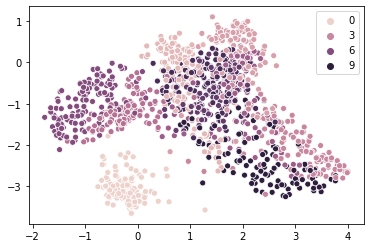

In [6]:
x_latent = p2.detach().numpy()

plt.figure()
sns.scatterplot(x_latent[:, 0], x_latent[:, 1], hue=y_train_np)
plt.show()

Define a new autoencoder to learn hierarchical clusters:
- the encoder will provide a hierarchical *agglomerative* clustering
- the decoder will provide a hierarchical *divisive* clustering

In [7]:
class AutoencoderDual(nn.Module):
    def __init__(self, input_size):
        super(AutoencoderDual, self).__init__()
        
        self.input_size = input_size
        
        self.elu = nn.ELU()
        self.enc1 = nn.Linear(in_features=input_size, out_features=input_size//5)
        self.enc2 = nn.Linear(in_features=input_size//5, out_features=input_size//20)
 
        # decoder 
        self.dec1 = nn.Linear(in_features=input_size//20, out_features=input_size//5)
        self.dec2 = nn.Linear(in_features=input_size//5, out_features=input_size)
 
    def forward(self, x):
        p1 = self.enc1(x)
        p1 = self.elu(p1)
        p2 = self.enc2(p1)
        p2 = self.elu(p2)
        
        p3 = self.dec1(p2)
        p3 = self.elu(p3)
        p4 = self.dec2(p3)
        p4 = self.elu(p4)
        return p1, p2, p3, p4

Our loss function will be the quantization error:

In [13]:
def quantization(p, x):
    # squared distance
    row_norms_A = torch.sum(p.pow(2), dim=1)
    row_norms_A = torch.reshape(row_norms_A, [-1, 1])  # Column vector.
    row_norms_B = torch.sum(x.pow(2), dim=1)
    row_norms_B = torch.reshape(row_norms_B, [1, -1])  # Row vector.
    D = row_norms_A - 2 * torch.matmul(p, x.T) + row_norms_B
    
    d_min = torch.min(D, dim=0)[0]
    Q = torch.norm(d_min)
    return Q

Let's train our new autoencoder:

In [14]:
x_latent = p2.detach().numpy()
scaler = MinMaxScaler((0, 1))
x_latent = scaler.fit_transform(x_latent)

x_latent = torch.FloatTensor(x_latent)
input_size = x_latent.shape[0]
model = AutoencoderDual(input_size)
print(model)
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)
model.train()
epoch = 400
for epoch in range(epoch):
    optimizer.zero_grad()
    
    # Forward pass
    prototypes = model(x_latent.T)

    # Compute Loss
    loss_p = torch.zeros((1,), requires_grad=True)
    for prototype in prototypes:
        loss_p = loss_p + quantization(prototype.T, x_latent)
    loss_bce = torch.nn.functional.mse_loss(prototype.T, x_latent)
    loss = loss_p + loss_bce
    
    if epoch % 100 == 0:
        print(f'Epoch {epoch + 1}: '
              f'loss: {loss.item():.4f} ')

    # Backward pass
    loss.backward()
    optimizer.step()

AutoencoderDual(
  (elu): ELU(alpha=1.0)
  (enc1): Linear(in_features=1203, out_features=240, bias=True)
  (enc2): Linear(in_features=240, out_features=60, bias=True)
  (dec1): Linear(in_features=60, out_features=240, bias=True)
  (dec2): Linear(in_features=240, out_features=1203, bias=True)
)
Epoch 1: loss: 28.1732 
Epoch 101: loss: 0.4021 
Epoch 201: loss: 0.3180 
Epoch 301: loss: 0.3032 


Prune prototypes (i.e. cluster centroids) without samples:

In [15]:
pm = model(x_latent.T)

pmr = []
for i, pmi in enumerate(pm):
    pmi = pmi.T

    row_norms_A = torch.sum(pmi.pow(2), dim=1)
    row_norms_A = torch.reshape(row_norms_A, [-1, 1])  # Column vector.
    row_norms_B = torch.sum(x_latent.pow(2), dim=1)
    row_norms_B = torch.reshape(row_norms_B, [1, -1])  # Row vector.
    D = row_norms_A - 2 * torch.matmul(pmi, x_latent.T) + row_norms_B

    d_min, prototype_idx = torch.min(D, dim=0)
    valid_prototypes = torch.unique(prototype_idx)
    pmri = pmi[valid_prototypes]
    
    pmr.append(pmri.detach().numpy())

Plot cluster centroids provided at each layer:

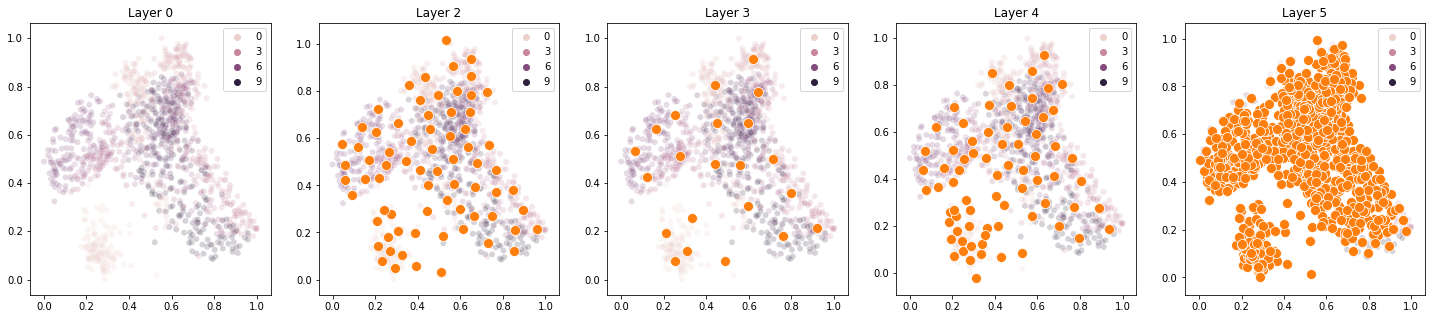

In [16]:
x_latent_np = x_latent.detach().numpy()

plt.figure(figsize=[25, 5])
plt.subplot(1, 5, 1)
plt.title(f'Layer 0')
sns.scatterplot(x_latent_np[:, 0], x_latent_np[:, 1], hue=y_train_np, alpha=0.2)
for i, pmi in enumerate(pmr):
    pmi = pmi
    plt.subplot(1, 5, i+2)
    plt.title(f'Layer {i+2}')
    sns.scatterplot(x_latent_np[:, 0], x_latent_np[:, 1], hue=y_train_np, alpha=0.2)
    sns.scatterplot(pmi[:, 0], pmi[:, 1], s=100)
plt.savefig('mnist_autoencoder_dual.png')
plt.show()